# Anomaly Detection Model

In [88]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import json
import pandas as pd
import numpy as np
import ccxt
from tqdm import tqdm
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score 
import pandas_ta as ta
from xgboost import XGBClassifier  
import lightgbm as lgbm 

with open("BTC_USDT-15m.json") as f: 
    d = json.load(f) 
    
chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 
                                    1:"open", 
                                    2:"high", 
                                    3:"low",
                                    4:"close",
                                    5:"volume"}) 

def process(df):
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = binance.iso8601(int(dates[i]))
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp 
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

chart_df.head()

,open,high,low,close,volume,datetime
0,4261.48,4280.56,4261.48,4261.48,2.189061,2017-08-17 04:00:00
1,4261.48,4270.41,4261.32,4261.45,9.119865,2017-08-17 04:15:00
2,4280.00,4310.07,4267.99,4310.07,21.923552,2017-08-17 04:30:00
3,4310.07,4313.62,4291.37,4308.83,13.948531,2017-08-17 04:45:00
4,4308.83,4328.69,4304.31,4304.31,5.101153,2017-08-17 05:00:00


In [89]:
close = chart_df["close"].values 
high = chart_df["high"].values 
low = chart_df["low"].values 

threshold = 0.006

targets = [] 
for i in range(len(close)-1):
    high_vol = (high[i+1]-close[i])/close[i] 
    low_vol = (low[i+1]-close[i])/close[i] 
    if high_vol >= threshold or low_vol <= -threshold:
        targets.append(1) 
    else:
        targets.append(0) 
        
targets.append(None) 

In [90]:
chart_df["Targets"] = targets

In [91]:
chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)

### addition of chart features ### 
chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
chart_df["vwap"] = chart_df.ta.vwap(lookahead=False) 
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"]


### addition of recent differenced features ### 
for l in tqdm(range(1, 12), position=0, leave=True): 
    for col in ["high", "low", "volume", "vwap"]:
        val = chart_df[col].values 
        val_ret = [None for _ in range(l)]
        for i in range(l, len(val)):
            if val[i-l] == 0: 
                ret = 1 
            else:
                ret = val[i] / val[i-l]  
            val_ret.append(ret) 
        chart_df["{}_change_{}".format(col, l)] = val_ret
        
### drop unnecessary columns ### 
chart_df.drop(columns={"open","high","low","close","volume","vwap","hwma","linreg"}, inplace=True) 


chart_df.dropna(inplace=True)

print(chart_df.shape)  

100%|██████████| 11/11 [00:04<00:00,  2.52it/s]


(176535, 56)


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Targets', ylabel='count'>

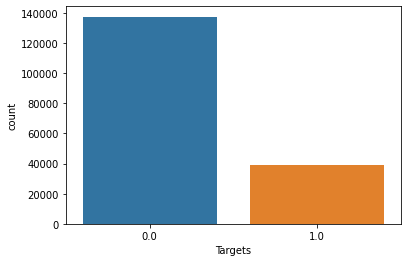

In [92]:
sns.countplot(chart_df["Targets"])

In [93]:
columns = chart_df.columns 

train_columns = [] 

for c in columns:
    if c not in ["year","datetime","Targets"]: 
        train_columns.append(c) 
        
        
train_idx = int(chart_df.shape[0] * 0.8) 
val_idx = int(chart_df.shape[0] * 0.1)
train_df, val_df, test_df = chart_df.iloc[:train_idx], chart_df.iloc[train_idx:train_idx+val_idx], chart_df.iloc[train_idx+val_idx:]


train_df.shape, val_df.shape, test_df.shape

((141228, 56), (17653, 56), (17654, 56))

In [94]:
chart_df.dropna(inplace=True)
X_train = train_df[train_columns] 
Y_train = train_df["Targets"]

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 


class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train) 

# d = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]} 

d = {0:class_weights[0], 1:class_weights[1]} 

print(d) 

{0: 0.6554780978195286, 1: 2.1079435207021104}


In [95]:
clf = XGBClassifier(silent=False, 
                    n_estimators=200,
                    class_weight=d, 
                    metric="logloss")

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=20)

[16:04:31] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.56150
[20]	validation_0-logloss:0.37351
[40]	validation_0-logloss:0.37351
[60]	validation_0-logloss:0.37407
[80]	validation_0-logloss:0.37546
[100]	validation_0-logloss:0.37591
[120]	validation_0-logloss:0.37645
[140]	validation_0-logloss:0.37733
[160]	validation_0-logloss:0.37805
[180]	validation_0-logloss:0.38008
[199]	validation_0-logloss:0.38125


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              class_weight={0: 0.6554780978195286, 1: 2.1079435207021104},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, metric='logloss',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [96]:
Y_pred = clf.predict(X_test) 
cnt = 0 
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test.values[i]:
        cnt += 1 
        
print("accuracy = {}%".format(cnt / len(Y_pred) * 100.))

accuracy = 86.16177636796193%


In [97]:
f1_score(Y_test, Y_pred, average='macro')

0.6796754259082048

In [98]:
Y_true = Y_test.values 
prob = clf.predict_proba(X_test)

In [99]:
confidence = [0.7, 0.8, 0.9, 0.95, 0.99] 

for c in confidence: 
    correct, wrong = 0, 0 
    for i in range(len(prob)):
        p = prob[i] 
        if p[1] >= c: 
            if Y_true[i] == 1:
                correct += 1 
            else:
                wrong += 1 
    print(c) 
    print(correct, wrong) 
    print(correct / (correct + wrong) * 100)
    print("===================================")

0.7
617 196
75.89175891758919
0.8
483 99
82.9896907216495
0.9
319 43
88.12154696132598
0.95
212 14
93.80530973451327
0.99
79 3
96.34146341463415


# Directional Prediction Model

In [195]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import json
import pandas as pd
import numpy as np
import ccxt
from tqdm import tqdm
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score 
import pandas_ta as ta
from xgboost import XGBClassifier  
import lightgbm as lgbm 

with open("BTC_USDT-15m.json") as f: 
    d = json.load(f) 
    
chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 
                                    1:"open", 
                                    2:"high", 
                                    3:"low",
                                    4:"close",
                                    5:"volume"}) 

def process(df):
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = binance.iso8601(int(dates[i]))
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp 
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

chart_df.head()

,open,high,low,close,volume,datetime
0,4261.48,4280.56,4261.48,4261.48,2.189061,2017-08-17 04:00:00
1,4261.48,4270.41,4261.32,4261.45,9.119865,2017-08-17 04:15:00
2,4280.00,4310.07,4267.99,4310.07,21.923552,2017-08-17 04:30:00
3,4310.07,4313.62,4291.37,4308.83,13.948531,2017-08-17 04:45:00
4,4308.83,4328.69,4304.31,4304.31,5.101153,2017-08-17 05:00:00


In [196]:
close = chart_df["close"].values 
high = chart_df["high"].values 
low = chart_df["low"].values 
threshold = 0.006
targets = [] 
for i in range(len(close)-1):
    high_vol = (high[i+1]-close[i])/close[i] 
    low_vol = (low[i+1]-close[i])/close[i] 
    if high_vol >= threshold or low_vol <= -threshold:
        if np.abs(high_vol) >= np.abs(low_vol):
            targets.append(0) 
        elif np.abs(high_vol) < np.abs(low_vol):
            targets.append(1) 
    else:
        targets.append(2) 
        
targets.append(None) 

In [197]:
chart_df["Targets"] = targets

In [198]:
chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)

### addition of chart features ### 
chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
chart_df["vwap"] = chart_df.ta.vwap(lookahead=False) 
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"]
chart_df["sma"] = chart_df.ta.sma(lookahead=False)
chart_df["sma/close"] = chart_df["sma"] / chart_df["close"]



### addition of recent differenced features ### 
for l in tqdm(range(1, 10), position=0, leave=True): 
    for col in ["high", "low", "volume", "vwap"]:
        val = chart_df[col].values 
        val_ret = [None for _ in range(l)]
        for i in range(l, len(val)):
            if val[i-l] == 0: 
                ret = 1 
            else:
                ret = val[i] / val[i-l]  
            val_ret.append(ret) 
        chart_df["{}_change_{}".format(col, l)] = val_ret
        
### drop unnecessary columns ### 
chart_df.drop(columns={"open","high","low","close","volume","vwap","hwma","linreg","sma"}, inplace=True) 


chart_df.dropna(inplace=True)

print(chart_df.shape)  

100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

(176535, 49)


In [199]:
chart_df = chart_df[chart_df["Targets"] != 2.0]

In [200]:
chart_df.shape

(39031, 49)

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Targets', ylabel='count'>

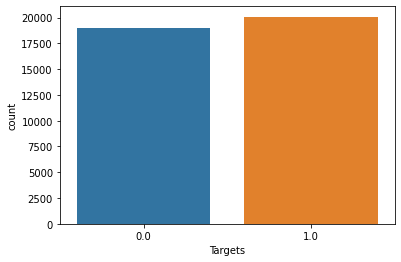

In [201]:
sns.countplot(chart_df["Targets"])

In [202]:
columns = chart_df.columns 

train_columns = [] 

for c in columns:
    if c not in ["year","datetime","Targets"]: 
        train_columns.append(c) 
        
        
train_idx = int(chart_df.shape[0] * 0.8) 
val_idx = int(chart_df.shape[0] * 0.1)
train_df, val_df, test_df = chart_df.iloc[:train_idx], chart_df.iloc[train_idx:train_idx+val_idx], chart_df.iloc[train_idx+val_idx:]


train_df.shape, val_df.shape, test_df.shape

((31224, 49), (3903, 49), (3904, 49))

In [203]:
chart_df.dropna(inplace=True)
X_train = train_df[train_columns] 
Y_train = train_df["Targets"]

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 


class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train) 

# d = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2]} 

d = {0:class_weights[0], 1:class_weights[1]} 

print(d) 

{0: 1.0342497515733686, 1: 0.9679459358918718}


In [204]:
directional_model = XGBClassifier(silent=False, 
                                  n_estimators=200,
                                  class_weight=d, 
                                  metric="logloss")

directional_model.fit(X_train, 
                      Y_train, 
                      eval_set=[(X_val, Y_val)],
                      verbose=20)

[16:19:35] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.69001
[20]	validation_0-logloss:0.69366
[40]	validation_0-logloss:0.69776
[60]	validation_0-logloss:0.69986
[80]	validation_0-logloss:0.70524
[100]	validation_0-logloss:0.70997
[120]	validation_0-logloss:0.71645
[140]	validation_0-logloss:0.72063
[160]	validation_0-logloss:0.72490
[180]	validation_0-logloss:0.72746
[199]	validation_0-logloss:0.72922


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              class_weight={0: 1.0342497515733686, 1: 0.9679459358918718},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, metric='logloss',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [205]:
Y_pred = directional_model.predict(X_test) 
cnt = 0 
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test.values[i]:
        cnt += 1 
        
print("accuracy = {}%".format(cnt / len(Y_pred) * 100.))

accuracy = 57.146516393442624%


In [206]:
f1_score(Y_test, Y_pred, average='macro') 

0.5693902368673058

In [208]:
cnt = 0 
for i in range(len(Y_test)):
    if Y_test.values[i] == 1:
        cnt += 1 

In [209]:
cnt / len(Y_test) * 100

50.92213114754098

In [211]:
cnt = 0 
for i in range(len(Y_test)):
    if Y_test.values[i] == 0:
        cnt += 1 
        
cnt / len(Y_test) * 100

49.07786885245902